In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import copy

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

#import PT_files.save_load as sl
import loader
import time 
from collections import OrderedDict
import pdb

# Loading data/dataloaders

Below are our 2 datasets we'll be working with. Aptly named, `train_data` is the larger of the datasets due to this set being what the model is trained on. `test_data` is the smaller dataset used to see how well our model is doing. Do to the small dataset nature we only have a training and test sets. 

In [2]:
#Load the actual data that we're working on & print the shape of this data
train_data = loader.load('training_data610-2000.npy')
test_data = loader.load('test_data200-2000.npy')
print('Shape of train set=', train_data.shape)

Shape of train set= (2, 610, 1, 2000, 2000)


Converting training/test data to be RGB instead of grayscale because the model expects the data to be RGB

In [3]:
train_noise_rgb = np.concatenate((train_data[0],)*3, axis=1)
train_clean_rgb = np.concatenate((train_data[1],)*3, axis=1)

test_noise_rgb = np.concatenate((test_data[0],)*3, axis=1)
test_clean_rgb = np.concatenate((test_data[1],)*3, axis=1)

In [4]:
train_data_rgb = np.empty((2, 610, 3, 2000, 2000), np.float32)
train_data_rgb[0, :, :, :, :] = train_noise_rgb
train_data_rgb[1, :, :, :, :] = train_clean_rgb

test_data_rgb = np.empty((2, 200, 3, 2000, 2000), np.float32)
test_data_rgb[0, :, :, :, :] = test_noise_rgb
test_data_rgb[1, :, :, :, :] = test_clean_rgb

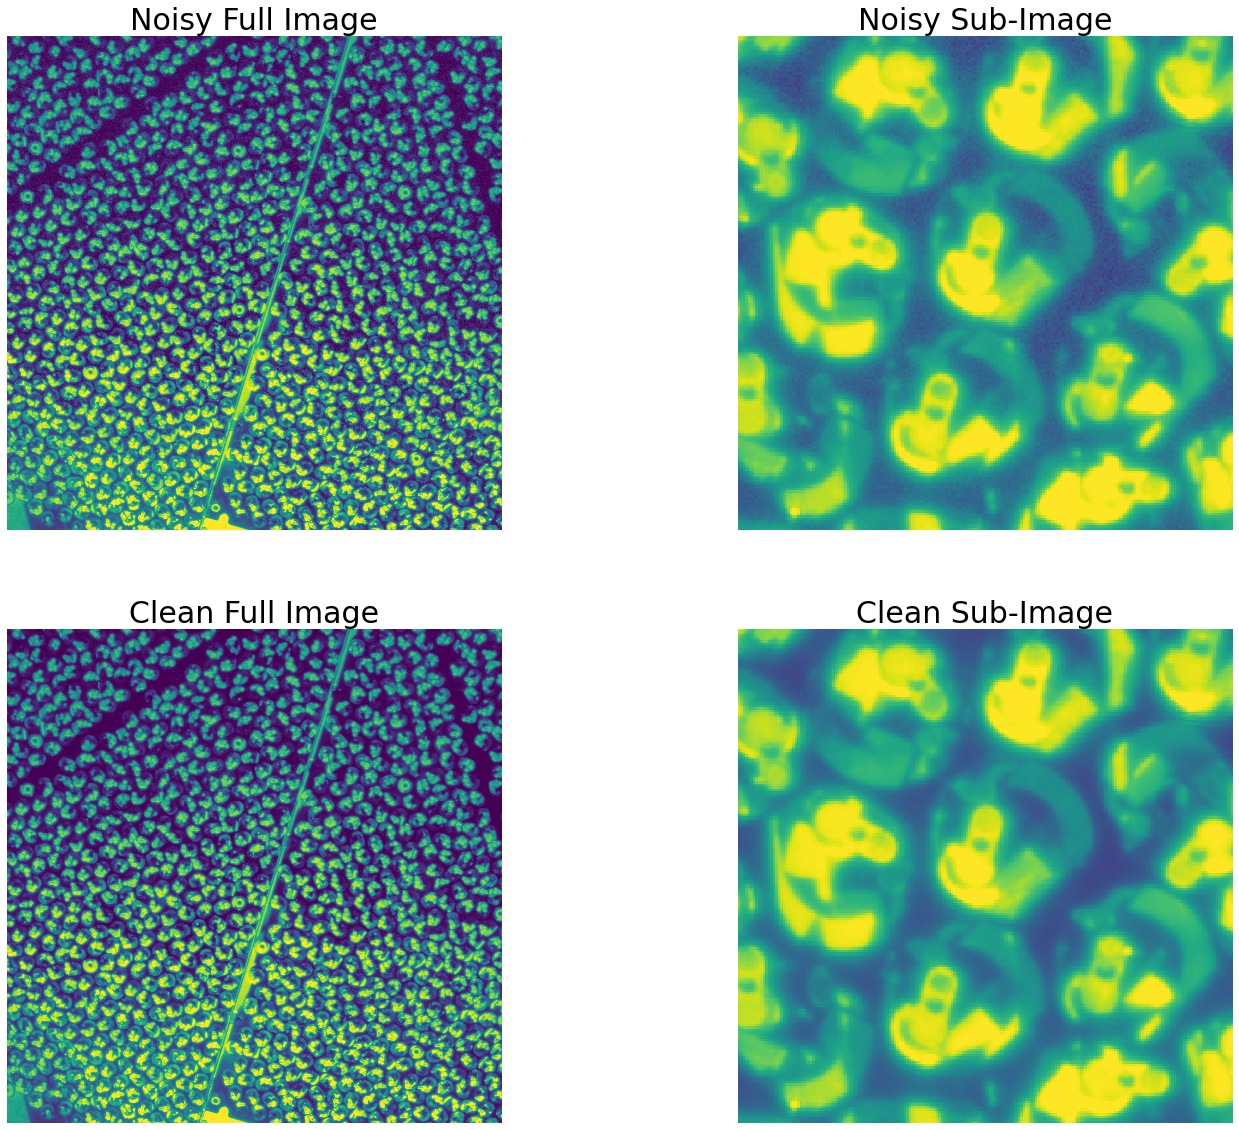

In [5]:
def display_data(data, sample_id, height, width):
    
    noise = data[0]
    label = data[1]
    
    fig, ax = plt.subplots(2, 2, figsize=(24,20))
    vmin, vmax = np.percentile(noise[sample_id], (1,99))


    ax[0, 0].imshow(noise[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0, 0].set_title('Noisy Full Image', fontsize=30)
    ax[0, 0].axis('off')
    ax[0, 1].imshow(noise[sample_id][0][height:height+200, width:width+200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0, 1].set_title('Noisy Sub-Image', fontsize=30)
    ax[0, 1].axis('off')
    ax[1, 0].imshow(label[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1, 0].set_title('Clean Full Image', fontsize=30)
    ax[1, 0].axis('off')
    ax[1, 1].imshow(label[sample_id][0][height:height+200, width:width+200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1, 1].set_title('Clean Sub-Image', fontsize=30)
    ax[1, 1].axis('off')

display_data(data=train_data_rgb, sample_id=0, height=100, width=300)

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. [Source of this blurb and more info on PyTorch Dataset and Dataloaders found here.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

This is our unique class to put our data, which in Numpy arrays, into the PyTorch primitive,`Dataset`. This will then be used in the other PyTorch primitive `Dataloader`.

In [6]:
class Img_Dataset(Dataset):
    def __init__(self, data_set, patch_size, width, height, seed=1234):
        """
        Parameters:
        -----------
        data: np.ndarray
            Array that contains image/label pairs ie. corrupted image/clean image.
            Shape = (P, N, C, H, W):
                P = corrupted/uncorrupted image pair 
                N = number of samples
                C = number of channels
                H = image height
                W = image width
        patch_size: int
            Size of randomly chosen image patch the model uses for training
        width: int
            Width of the chosen sample.
            NOTE: It's a parameter because you can input a larger image and choose
                  to look at only portions of said image for more training samples.
        height: int
            Height of the chosen sample.
        seed: int 
            Randomized seed used for the random slicing used to create the image patch.
        """
        self.data_set = data_set
        self.patch_size = patch_size
        self.width = width
        self.height = height
        self.seed = seed

    def __len__(self):
        return len(self.data_set[0])

    def __getitem__(self, idx):
        """
        Function that returns the PyTorch Dataloader compatible dataset.
        
        Parameters:
        -----------
        idx: var
            Variable used in PyTorch Dataloader to be able to sample from the dataset
            to create minibatches of the data for us automatically.
        """
        # Loading the dataset and then slicing the image/label pairs 
        # ie. corrupted/uncorrupted images. 
        # Note the use of the idx in the image/label variables. This allows the
        # PyTorch Dataloader to get all the important data info eg. (N, C, H, W)
        data = self.data_set
        image = data[0, idx]
        label = data[1, idx]
        
        # Setting the patch size and the randomized seed for the image patch
        patch_size = self.patch_size
        seed = self.seed
        rng = np.random.RandomState(seed)

        img_width = self.width
        img_height = self.height
        
        #randomly crop patch from training set
        x1 = rng.randint(img_width - patch_size)
        y1 = rng.randint(img_height - patch_size)
        S = (slice(y1, y1 + patch_size), slice(x1, x1 + patch_size))
        
        # create new arrays for training patchs
        image_patch = image[0][S]
        label_patch = label[0][S]
        

        image_patch = image_patch[np.newaxis, :, :]
        label_patch = label_patch[np.newaxis, :, :]
        
        # Turning our image/label to a PyTorch Tensor with dtype = float 
        # and then putting it onto the GPU for faster training/inference
        image = torch.from_numpy(image_patch).float().cuda(device)
        label = torch.from_numpy(label_patch).float().cuda(device)
            
        return image, label

# **LOOK HERE PATRICK**

In [34]:
data=train_data_rgb

image = data[0, :]
label = data[1, :]
print(image.shape)

# Setting the patch size and the randomized seed for the image patch
patch_size = 64
seed = 234
rng = np.random.RandomState(seed)

img_width = 2000
img_height = 2000

#randomly crop patch from training set
x1 = rng.randint(img_width - patch_size)
y1 = rng.randint(img_height - patch_size)
S = (slice(y1, y1 + patch_size), slice(x1, x1 + patch_size))

y_patch = (y1, y1 + patch_size)
x_patch = (x1, x1 + patch_size)
print(y_patch)
print(x_patch)
# print('Slice = ',S)
# create new arrays for training patchs
image_patch = image[0][:][y_patch[0]:y_patch[1], x_patch[0]:x_patch[1]]

print(image_patch.shape)




# label_patch = label[0][S]


image_patch = image_patch[np.newaxis, :, :]
label_patch = label_patch[np.newaxis, :, :]

# # Turning our image/label to a PyTorch Tensor with dtype = float 
# # and then putting it onto the GPU for faster training/inference
# image = torch.from_numpy(image_patch).float().cuda(device)
# label = torch.from_numpy(label_patch).float().cuda(device)

print('Patch =', image_patch.shape)

(610, 3, 2000, 2000)
(324, 388)
(456, 520)
(0, 64, 2000)
Patch = (1, 0, 64, 2000)


In [19]:
train_data_rgb.shape

(2, 610, 3, 2000, 2000)

In [8]:
train_ds = Img_Dataset(data_set=train_data_rgb,
                       patch_size=64,
                       height=2000,
                       width=2000)

test_ds = Img_Dataset(data_set=test_data_rgb,
                       patch_size=64,
                       height=2000,
                       width=2000)

Output of the `dataloader` is channel of 1, when the model wants it to be 3. If you scroll all the way to the bottom you'll see the error saying `Given groups=1, weight of size [64, 3, 7, 7], expected input[56, 1, 64, 64] to have 3 channels, but got 1 channels instead`.

I think once it's the correct channel size it should be working.

Also, just so you know I had to make the data rgb instead of grayscale, so the above cells have that code, but I don't think it changes anything really.

In [9]:
train_dataloader = DataLoader(train_ds, batch_size=56, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([56, 1, 64, 64])
Labels batch shape: torch.Size([56, 1, 64, 64])


What the training pair looks like:

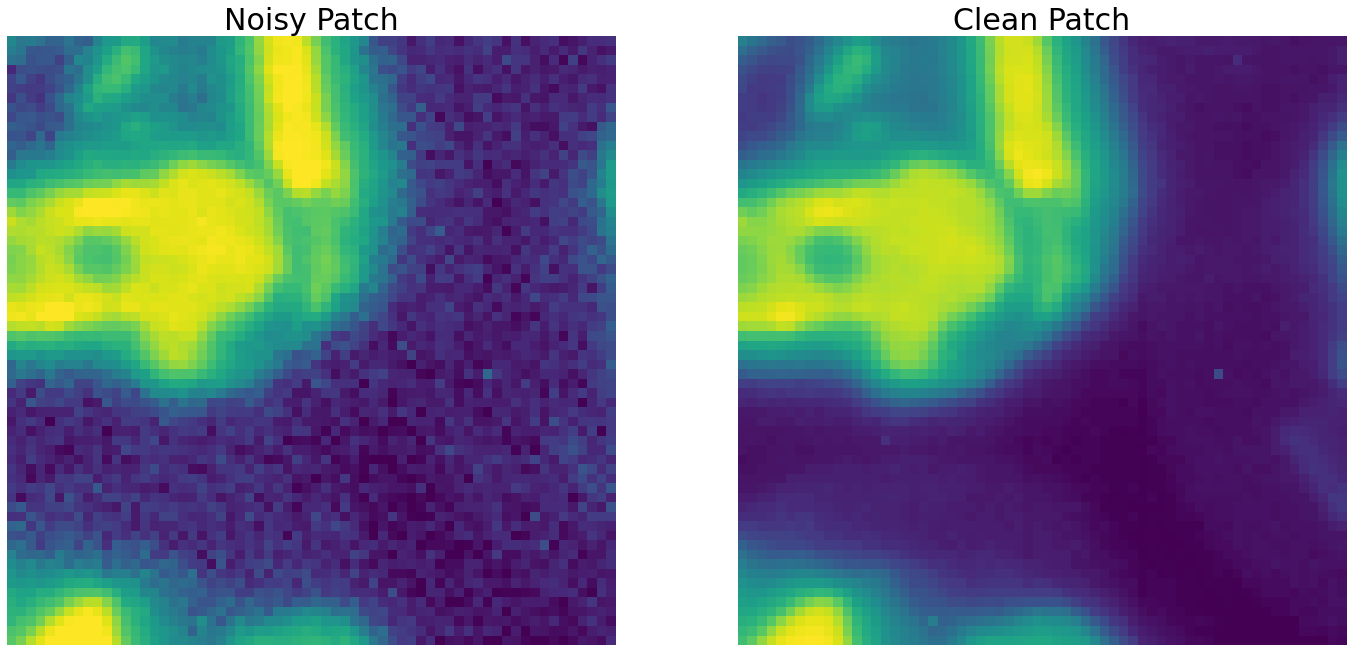

In [10]:
def display_training_pair(dataloader, sample_id):
    
    images, labels = next(iter(dataloader))    
    images = images.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    
    fig, ax = plt.subplots(1, 2, figsize=(24,20))
    vmin, vmax = np.percentile(images[sample_id][0], (1,99))


    ax[0].imshow(images[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].set_title('Noisy Patch', fontsize=30)
    ax[0].axis('off')
    ax[1].imshow(labels[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].set_title('Clean Patch', fontsize=30)
    ax[1].axis('off')
    
display_training_pair(dataloader=train_dataloader, sample_id=0)

PFF uses the model titled `PixelEmbedModelResNet18` 

The model the paper describes using is the model titled `PixelEmbedModelResNet18` on Github under, unsurprisingly, the directory titled `pixel_embedding_model.py`. 
- The down-sampling first stream for PFF uses a tweaked pretrained ResNet18 architecture.
- The shallow full-resolution second stream is titled `self.streamTwo_feats` (I believe).

# Trying to get the papers code working for our FVC images

Config parameters

In [11]:
batch_size = 16 # small batch size for demonstration; using larger batch size (like 56 and 64) for training

embedding_dim = 16 # dimension of the learned embedding space
kernel_size = 17 # the kernel size in the filter flow
cropSize = [64, 64] # patch size for training the model
sigmaMin=0.5
sigmaMax=2

lambda_norm = 0.1
total_epoch_num = 500 # total number of epoch in training
base_lr = 0.0005

Model architecture

In [12]:
class PixelEmbedModelResNet18(nn.Module):
    def __init__(self, emb_dimension=128, pretrained=True):
        super(PixelEmbedModelResNet18, self).__init__()
        self.emb_dimension = emb_dimension        
        
        resnet = models.resnet18(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        
                
        # tweak resnet backbone to output features 8x smaller than input image
        for n, m in self.layer3.named_modules():
            if 'conv1' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
        for n, m in self.layer4.named_modules():
            if 'conv1' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
        
        self.streamTwo_feats = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
        )
        
                
        self.block5_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer4[-1].conv2.out_channels, emb_dimension, 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension)
        )            
        self.block5_feats = nn.Sequential(
            nn.Conv2d(emb_dimension, emb_dimension, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension),
            
            nn.Conv2d(emb_dimension, emb_dimension, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension)
        )
        
                
        self.layer1_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer1[-1].conv2.out_channels, int(emb_dimension/2), 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        self.layer1_feats = nn.Sequential(
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2)),
            
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
                        
                
        self.layer2_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer2[-1].conv2.out_channels, int(emb_dimension/2), 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        self.layer2_feats = nn.Sequential(
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2)),
            
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
                

        self.layer3_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer3[-1].conv2.out_channels, int(emb_dimension/2), 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        self.layer3_feats = nn.Sequential(
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2)),
            
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        
        
        self.emb = nn.Sequential(
            nn.Conv2d(int(emb_dimension*2.5+32), emb_dimension, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension),
            
            nn.Conv2d(emb_dimension, emb_dimension, kernel_size=3, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension)
        )
        
        
    def forward(self, inputs):
        self.interp_x4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)  
        self.interp_x8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)  
        
        input_size = inputs.size()
        
        out = self.layer0(inputs)
        out_stream2 = self.streamTwo_feats(inputs)        
        
        out = self.layer1(out)        
        out_layer1 = self.layer1_dimRed(out)        
        out_layer1 = self.interp_x4(out_layer1)
        out_layer1 = self.layer2_feats(out_layer1)
        
        out = self.layer2(out)
        
        out_layer2 = self.layer2_dimRed(out)        
        out_layer2 = self.interp_x8(out_layer2)
        out_layer2 = self.layer2_feats(out_layer2)
        
        
        out = self.layer3(out)
        
        out_layer3 = self.layer3_dimRed(out)        
        out_layer3 = self.interp_x8(out_layer3)
        out_layer3 = self.layer3_feats(out_layer3)
        
        
        out = self.layer4(out)
        
        out = self.block5_dimRed(out)
        self.interp = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)        
        out = self.interp(out)        
        out = self.block5_feats(out)
            
     
        out = torch.cat([out_stream2, out_layer1, out_layer2, out_layer3, out], 1)
        out=self.emb(out)
                
        return out      
    

In [13]:
class SiamesePixelEmbed(nn.Module):
    def __init__(self, emb_dimension=64, filterSize=11, device='cuda', pretrained=False):
        super(SiamesePixelEmbed, self).__init__()
        self.device = device
        self.emb_dimension = emb_dimension  
        self.PEMbase = PixelEmbedModelResNet18(emb_dimension=self.emb_dimension, pretrained=pretrained)  
        self.rawEmbFeature1 = 0
        self.rawEmbFeature2 = 0        
        self.embFeature1_to_2 = 0
        self.embFeature1_to_2 = 0
        self.filterSize = filterSize
        self.filterSize2Channel = self.filterSize**2
                
        self.ordered_embedding = nn.Sequential(            
            nn.Conv2d(self.emb_dimension, self.filterSize2Channel, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(self.filterSize2Channel),     
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(self.filterSize2Channel),            
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, padding=1, bias=True)
        )
        
        
    def forward(self, inputs1, inputs2):        
        self.rawEmbFeature1 = self.PEMbase.forward(inputs1)
        
        self.embFeature1_to_2 = self.ordered_embedding(self.rawEmbFeature1)        
        self.embFeature1_to_2 = F.softmax(self.embFeature1_to_2, 1)
        
        return self.embFeature1_to_2

Define loss function

In [14]:
class LossOrderedPairReconstruction(nn.Module):
    def __init__(self, device='cuda', filterSize=11):
        super(LossOrderedPairReconstruction, self).__init__()
        self.device = device
        self.filterSize = filterSize        
        self.filterSize2Channel = self.filterSize**2
        self.reconstructImage = 0
        
    def forward(self, image1, image2, filters_img1_to_img2):
        N,C,H,W = image1.size()
        self.reconstructImage = self.rgbImageFilterFlow(image1, filters_img1_to_img2)
        diff = self.reconstructImage - image2               
        diff = torch.abs(diff)       
        totloss = torch.sum(torch.sum(torch.sum(torch.sum(diff))))        
        return totloss/(N*C*H*W)
    
    
    def rgbImageFilterFlow(self, img, filters):                
        inputChannelSize = 1
        outputChannelSize = 1
        N = img.size(0)
        paddingFunc = nn.ZeroPad2d(int(self.filterSize/2))
        img = paddingFunc(img)        
        imgSize = [img.size(2),img.size(3)]
        
        out_R = F.unfold(img[:,0,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_R = out_R.view(N, out_R.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_R = paddingFunc(out_R)
        out_R = torch.mul(out_R, filters)
        out_R = torch.sum(out_R, dim=1).unsqueeze(1)

        out_G = F.unfold(img[:,1,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_G = out_G.view(N, out_G.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_G = paddingFunc(out_G)
        out_G = torch.mul(out_G, filters)
        out_G = torch.sum(out_G, dim=1).unsqueeze(1)

        out_B = F.unfold(img[:,2,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_B = out_B.view(N, out_B.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_B = paddingFunc(out_B)
        out_B = torch.mul(out_B, filters)
        out_B = torch.sum(out_B, dim=1).unsqueeze(1)
        return torch.cat([out_R, out_G, out_B], 1)

Trying to get their training demo work for our data

In [15]:
################## init model ###################
initModel = SiamesePixelEmbed(emb_dimension=embedding_dim, 
                              filterSize=kernel_size,
                              device=device, pretrained=False)

# initModel.load_state_dict(torch.load(os.path.join(exp_dir,'epoch-445.paramOnly')))
initModel.to(device);


# decreasing the momentum in batch normalization, as the default is too large for this work.
allLayer_dict = initModel.state_dict()
child_counter = 0
for child in initModel.PEMbase.children():
    for i in range(len(child)):        
        if 'BatchNorm2d' in str(type(child[i])): 
            child[i].momentum=0.001
            #print(child[i])            

for i in range(len(initModel.ordered_embedding)):    
    if 'BatchNorm2d' in str(type(initModel.ordered_embedding[i])): 
            initModel.ordered_embedding[i].momentum=0.001
            #print(initModel.ordered_embedding[i])
            
child_counter = 0
for child in initModel.children():
    #print(" child", child_counter, "is:")
    #print(child)
    child_counter += 1 

Path for this training_log to be stored

In [16]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()

Create training loop function for our model

**NOTE:** If running this on your laptop and you haven't downloaded the requisite packages for training on your GPU, set `device='cpu'` to run.

In [17]:
def train_model(model, dataloaders, dataset_sizes, loss_1_to_2, optimizer, scheduler, 
                num_epochs=25, work_dir='./', device='cuda'):
    
    log_filename = os.path.join(work_dir,'train.log')    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):        
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        fn = open(log_filename,'a') # 'a' stands for append 
        fn.write('\nEpoch {}/{}\n'.format(epoch+1, num_epochs))
        fn.write('--'*5+'\n')
        fn.close()

        
        scheduler.step() # Moves the 
        model.train()
        
        running_loss = 0.0
        
        # Iterate over data.
        iterCount, sampleCount = 0, 0
        for sample in dataloaders:
            noisy_samples, clean_samples = sample
            noise_samples = noisy_samples.to(device) # Putting images onto GPU
            clean_samples = clean_samples.to(device)
            
            # Zero the parameter gradients
            # Want to do this b/c pytorch tracks gradients and if you don't
            # zero them out you'll have the new grads you learned added to 
            # previous layer gradients, which reduces effectivity of learning
            optimizer.zero_grad()
            
            # Forward pass (ie. run data thru model then update params via
            # backpropogation, which is what this torch.set_grad_enabled(True)'
            # does. It allows for the gradients to be remembered in the 
            # computation graph, which is how PyTorch relates each nodes input 
            # and output together. (Ask me if this literally makes no sense)
            with torch.set_grad_enabled(True):
                model.train() # Need to set this b/c model layers might act diff
                embFeature1_to_2 = model(noisy_samples, clean_samples)
                loss = loss_1_to_2(noisy_samples, clean_samples, embFeature1_to_2)
                loss.backward() # Calcs the gradients of loss wrt every param w/ 
                                # requires_grad=True. If confused just google.
                                # PyTorch documentation is lit.
        


                # statistics  
                iterCount += 1
                sampleCount += noisy_samples.size(0)                                
                running_loss += loss.item() * noisy_samples.size(0)                                
                print2screen_avgLoss = running_loss/sampleCount
                                               
                if iterCount%50==0:
                    print('\t{}/{} loss: {:.6f}'.format(iterCount, len(dataloaders), print2screen_avgLoss))
                    fn = open(log_filename,'a')        
                    fn.write('\t{}/{} loss: {:.6f}\n'.format(iterCount, len(dataloaders), print2screen_avgLoss))
                    fn.close()
  
            epoch_loss = running_loss / dataset_sizes
                                
            print('\tloss: {:.6f}'.format(epoch_loss))
            fn = open(log_filename,'a')
            fn.write('\tloss: {:.6f}\n'.format(epoch_loss))
            fn.close()
                    
                
            # deep copy the model
            cur_model_wts = copy.deepcopy(model.state_dict())
            path_to_save_paramOnly = os.path.join(work_dir, 'epoch-{}.paramOnly'.format(epoch+1))
            torch.save(cur_model_wts, path_to_save_paramOnly)
            
        
                
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    fn = open(log_filename,'a')
    fn.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    fn.close()
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [18]:
################## loss function ###################
loss_1_to_2 = LossOrderedPairReconstruction(device=device, filterSize=kernel_size)

loss_l1norm = nn.L1Loss(size_average=True)

optimizer_ft = optim.Adam([{'params': initModel.PEMbase.parameters()},
                           {'params': initModel.ordered_embedding.parameters(), 'lr': base_lr},                           
                         ], lr=base_lr)


# Decay LR by a factor of 0.5 every int(total_epoch_num/5) epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=int(total_epoch_num/5), gamma=0.5)

################## start training ###################
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()

save_dir = DATA
log_filename = os.path.join(save_dir, 'PFF_train.log')


fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

model_ft = train_model(initModel, train_dataloader, len(train_ds), 
                       loss_1_to_2, 
                       optimizer_ft, exp_lr_scheduler,
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, device=device)

/global/common/software/nersc/shasta2105/pytorch/1.9.0/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/global/common/software/nersc/shasta2105/pytorch/1.9.0/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch 1/500
----------


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[56, 1, 64, 64] to have 3 channels, but got 1 channels instead